# RF Complexity Analysis (EU)
## Data Loading

We use the `forest_report.json` file in the repo. Each entry contains the dataset name, metadata (sizes, series length, split), and trained forest statistics.

In [12]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Mapping
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('seaborn-v0_8-whitegrid')

# Optional styling (if unavailable, neutral fallback)
try:
    from etl.table_styling import style_summary_table, print_color_legend
except Exception:
    def style_summary_table(df: pd.DataFrame):
        return df.style
    def print_color_legend():
        pass

REPORT_PATH = Path('forest_report.json')
assert REPORT_PATH.exists(), f'File not found: {REPORT_PATH}'
with REPORT_PATH.open('r', encoding='utf-8') as f:
    report_data: list[dict[str, Any]] = json.load(f)
print(f'Loaded {len(report_data)} rows from {REPORT_PATH}')



Loaded 88 rows from forest_report.json


## Summary Table

We build a table with: `dataset`, `analyzed` (if results exist in `results/`), `n_estimators`, EU complexity metrics (`n_features`, `mean_eu`, `eu_complexity`), sizes (`series_length`, `train_size`, `test_size`), and forest stats (`avg_depth`, `avg_leaves`, `avg_nodes`).

Correct sorting (priority):
- `n_estimators` ascending
- `eu_complexity` ascending (fallback to `series_length` when missing)
- `series_length` ascending
- `dataset` alphabetical


In [13]:
# Cell 6 — Build table with correct sorting (EU count)
def to_int(value: Any | None) -> int | None:
    try:
        return int(value)
    except (TypeError, ValueError):
        return None

def to_float(value: Any | None) -> float | None:
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

def extract_metadata(entry: Mapping[str, Any]) -> dict[str, Any]:
    metadata = entry.get('metadata') if isinstance(entry.get('metadata'), Mapping) else {}
    statistics = entry.get('forest_statistics') if isinstance(entry.get('forest_statistics'), Mapping) else {}
    dataset = str(entry.get('dataset', '') or '').strip() or '<unknown>'
    return {
        'dataset': dataset,
        'n_estimators': to_int(statistics.get('n_estimators')),
        'series_length': to_int(metadata.get('series_length')),
        'train_size': to_int(metadata.get('train_size')),
        'test_size': to_int(metadata.get('test_size')),
        'avg_depth': to_float(statistics.get('avg_depth')),
        'avg_leaves': to_float(statistics.get('avg_leaves')),
        'avg_nodes': to_float(statistics.get('avg_nodes')),
    }

def build_eu_metrics(entries: list[Mapping[str, Any]]) -> dict[str, dict[str, Any]]:
    eu: dict[str, dict[str, Any]] = {}
    for e in entries:
        dataset = str(e.get('dataset', '') or '').strip()
        if not dataset:
            continue
        n_features = e.get('n_features') if isinstance(e.get('n_features'), (int, float)) else None
        mean_eu = e.get('mean_eu') if isinstance(e.get('mean_eu'), (int, float)) else None
        eu_complexity = e.get('eu_complexity') if isinstance(e.get('eu_complexity'), (int, float)) else None
        # Try deriving from endpoint dictionaries (consider common key variants)
        eu_obj = e.get('endpoints_universe') or e.get('endpoints') or e.get('endpoints_universe_summary')
        lengths = None
        if isinstance(eu_obj, Mapping):
            lens: list[int] = []
            for _, endpoints in eu_obj.items():
                if isinstance(endpoints, (list, tuple)):
                    lens.append(len(endpoints))
            if lens:
                lengths = lens
                comp_n = len(lens)
                comp_mean = float(np.mean(lens))
                comp_cplx = comp_mean * comp_n
                if n_features is None:
                    n_features = comp_n
                if mean_eu is None:
                    mean_eu = comp_mean
                if eu_complexity is None:
                    eu_complexity = comp_cplx
        if n_features is not None and mean_eu is not None:
            eu[dataset] = {
                'n_features': int(n_features),
                'mean_eu': float(mean_eu),
                'eu_complexity': float(eu_complexity) if eu_complexity is not None else float(mean_eu) * int(n_features),
                'lengths': lengths,
            }
    return eu

# Build summary dataframe + EU metrics
summary_df = pd.DataFrame([extract_metadata(e) for e in report_data])
eu_metrics = build_eu_metrics(report_data)

summary_df['n_features'] = summary_df['dataset'].apply(lambda d: eu_metrics.get(d, {}).get('n_features'))
summary_df['mean_eu'] = summary_df['dataset'].apply(lambda d: eu_metrics.get(d, {}).get('mean_eu'))
summary_df['eu_complexity'] = summary_df['dataset'].apply(lambda d: eu_metrics.get(d, {}).get('eu_complexity'))

# 'analyzed' column if zip files exist in results/
results_dir = Path('results')
if results_dir.exists():
    zips = [p.name for p in results_dir.iterdir() if p.is_file() and p.suffix == '.zip']
    done = {name.split('_')[0] for name in zips}
    summary_df['analyzed'] = summary_df['dataset'].apply(lambda d: 'YES' if d in done else 'NO')
else:
    summary_df['analyzed'] = 'N/A'

# Sorting: n_estimators → eu_complexity (fallback series_length) → series_length → dataset
INF = float('inf')
summary_df['_sort_n_estimators'] = summary_df['n_estimators'].fillna(INF)
summary_df['_sort_eu'] = summary_df.apply(
    lambda r: r['eu_complexity'] if pd.notna(r.get('eu_complexity')) else (r['series_length'] if pd.notna(r.get('series_length')) else INF),
    axis=1,
)
summary_df['_sort_series_length'] = summary_df['series_length'].fillna(INF)
summary_df = (
    summary_df
    .sort_values(['_sort_n_estimators', '_sort_eu', '_sort_series_length', 'dataset'], ascending=[True, True, True, True])
    .drop(columns=['_sort_n_estimators', '_sort_eu', '_sort_series_length'])
)
summary_df = summary_df.reset_index(drop=True)

eu_only_df = summary_df[summary_df['eu_complexity'].notna()].copy()

# Riordino colonne secondo la sequenza richiesta
desired_order = [
    'dataset', 'analyzed', 'n_estimators', 'eu_complexity',
    'series_length', 'mean_eu', 'n_features', 'train_size', 'test_size',
    'avg_depth', 'avg_leaves', 'avg_nodes'
]
summary_df = summary_df[[col for col in desired_order if col in summary_df.columns]]

style_summary_table(summary_df)


/Users/danielamadori/Projects/drifts/etl/table_styling.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(analyzed_style, subset=['analyzed'])


,dataset,analyzed,n_estimators,eu_complexity,series_length,mean_eu,n_features,train_size,test_size,avg_depth,avg_leaves,avg_nodes
0,Wine,NO,10.000000,297.000000,234,3.453488,86.000000,57,54,2.600000,4.400000,7.800000
1,Wafer,YES,10.000000,603.000000,152,4.674419,129.000000,1000,6164,6.800000,13.200000,25.400000
2,MiddlePhalanxOutlineCorrect,YES,10.000000,1440.000000,80,18.000000,80.000000,600,291,8.000000,35.600000,70.200000
3,MelbournePedestrian,YES,10.000000,1456.000000,24,60.666667,24.000000,1138,2319,9.300000,40.200000,79.400000
4,ChlorineConcentration,YES,10.000000,1792.000000,166,10.795181,166.000000,467,3840,15.100000,39.400000,77.800000
5,ScreenType,NO,10.000000,2618.000000,720,4.363333,600.000000,375,375,0.200000,1.200000,1.400000
6,FordA,NO,10.000000,8811.000000,500,17.622000,500.000000,3601,1320,10.300000,30.000000,59.000000
7,FordB,NO,10.000000,8964.000000,500,17.928000,500.000000,3636,810,12.200000,30.000000,59.000000
8,ElectricDevices,YES,10.000000,29847.000000,96,310.906250,96.000000,8926,7711,26.600000,360.900000,720.800000
9,SonyAIBORobotSurface1,YES,17.000000,106.000000,70,3.312500,32.000000,20,601,1.647059,2.705882,4.411765


In [14]:
analyzed_true_df = summary_df[summary_df['analyzed'] == 'YES']
#display(analyzed_true_df)
style_summary_table(analyzed_true_df)

/Users/danielamadori/Projects/drifts/etl/table_styling.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(analyzed_style, subset=['analyzed'])


,dataset,analyzed,n_estimators,eu_complexity,series_length,mean_eu,n_features,train_size,test_size,avg_depth,avg_leaves,avg_nodes
1,Wafer,YES,10.000000,603.000000,152,4.674419,129.000000,1000,6164,6.800000,13.200000,25.400000
2,MiddlePhalanxOutlineCorrect,YES,10.000000,1440.000000,80,18.000000,80.000000,600,291,8.000000,35.600000,70.200000
3,MelbournePedestrian,YES,10.000000,1456.000000,24,60.666667,24.000000,1138,2319,9.300000,40.200000,79.400000
4,ChlorineConcentration,YES,10.000000,1792.000000,166,10.795181,166.000000,467,3840,15.100000,39.400000,77.800000
8,ElectricDevices,YES,10.000000,29847.000000,96,310.906250,96.000000,8926,7711,26.600000,360.900000,720.800000
9,SonyAIBORobotSurface1,YES,17.000000,106.000000,70,3.312500,32.000000,20,601,1.647059,2.705882,4.411765
15,HandOutlines,YES,59.000000,2862.000000,2709,3.252273,880.000000,1000,370,9.338983,20.000000,39.000000
20,FacesUCR,YES,92.000000,1219.000000,131,9.376923,130.000000,200,2050,6.565217,19.630435,38.260870
25,ECG200,YES,101.000000,291.000000,96,4.041667,72.000000,100,100,3.069307,4.673267,8.346535


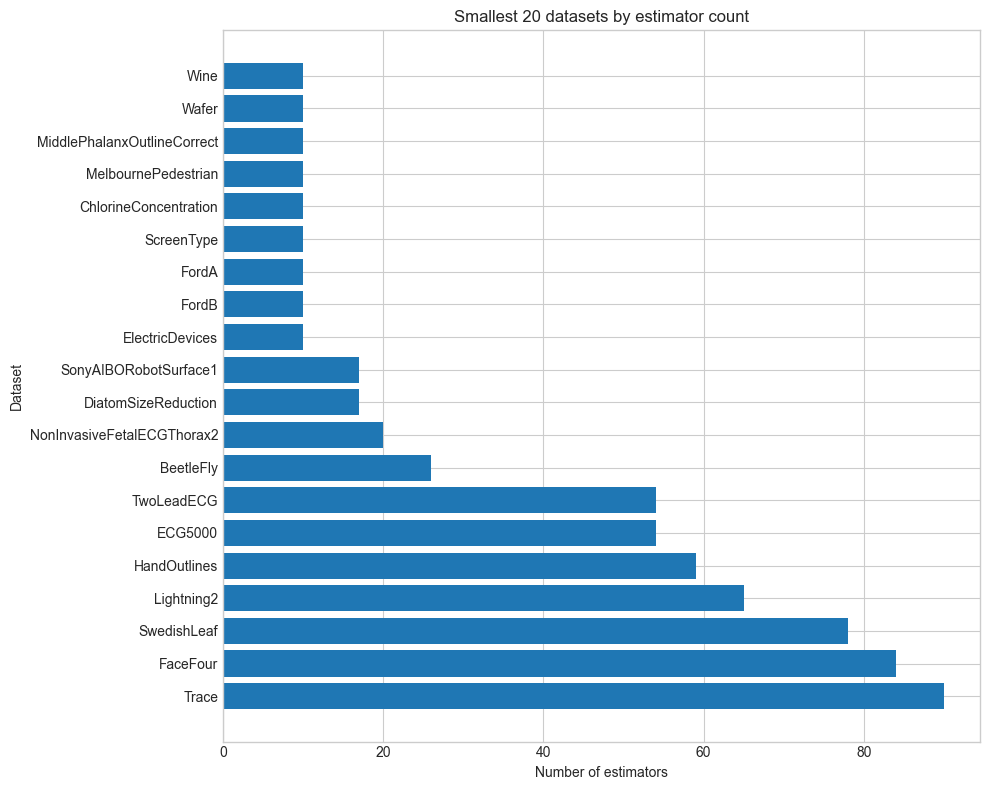

In [15]:
smallest_n = 20
least_complex = summary_df.head(smallest_n)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(least_complex['dataset'], least_complex['n_estimators'], color='#1f77b4')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Dataset')
ax.set_title(f'Smallest {smallest_n} datasets by estimator count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()